## GloFAS vs Google Forecast and Reanalysis Comparison

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import ocha_stratus as stratus
import numpy as np

from dotenv import load_dotenv

load_dotenv()

from src.datasources import glofas, grrr

SAPPHIRE = "#007ce0"
TOMATO = "#f2645a"
TOMATO_DARK = "#c25048"
TOMATO_LIGHT = "#f7a29c"
MINT = "#1ebfb3"
GREY_DARK = "#888888"
GREY_LIGHT = "#cccccc"

Get the Google data

In [3]:
ds_ra = grrr.load_reanalysis()
df_ra_grrr = grrr.process_reanalysis(ds_ra)

ds_rf = grrr.load_reforecast()
df_rf_grrr = grrr.process_reforecast(ds_rf)

/Users/hannahker/Desktop/ds-aa-nga-flooding/src/datasources/grrr.py:12: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


Get the GloFAS data

In [4]:
df_ra_glofas = glofas.load_reanalysis().rename(columns={"time": "valid_time"})
df_rf_glofas = glofas.load_reforecast()

Get the Floodscan data

In [5]:
df_fs_raw = stratus.load_parquet_from_blob(
    "ds-aa-nga-flooding/processed/floodscan/fs_benue_pixels_1998_2024.parquet"
)
df_fs = df_fs_raw.groupby("date")["SFED"].mean().reset_index()
df_fs = df_fs.rename(columns={"date": "valid_time"})

Compute return periods

In [6]:
df_ra_peaks_glofas = (
    df_ra_glofas.groupby(df_ra_glofas["valid_time"].dt.year.rename("year"))
    .agg(
        dis24_max=("dis24", "max"),
        dis24_max_date=(
            "dis24",
            lambda x: df_ra_glofas.loc[x.idxmax(), "valid_time"],
        ),
    )
    .reset_index()
)

df_ra_peaks_grrr = (
    df_ra_grrr.groupby(df_ra_grrr["valid_time"].dt.year.rename("year"))
    .agg(
        streamflow_max=("streamflow", "max"),
        streamflow_max_date=(
            "streamflow",
            lambda x: df_ra_grrr.loc[x.idxmax(), "valid_time"],
        ),
    )
    .reset_index()
)

df_peaks_fs = (
    df_fs.groupby(df_fs["valid_time"].dt.year.rename("year"))
    .agg(
        sfed_max=("SFED", "max"),
        sfed_max_date=(
            "SFED",
            lambda x: df_fs.loc[x.idxmax(), "valid_time"],
        ),
    )
    .reset_index()
)

rp = 3
rp_glofas = df_ra_peaks_glofas["dis24_max"].quantile(1 - 1 / rp)
rp_grrr = df_ra_peaks_grrr["streamflow_max"].quantile(1 - 1 / rp)
rp_fs = df_peaks_fs["sfed_max"].quantile(1 - 1 / rp)

Now plot the yearly peaks

In [7]:
df_all_peaks = df_ra_peaks_glofas.merge(df_ra_peaks_grrr, how="inner")
df_all_peaks_fs = df_all_peaks.merge(df_peaks_fs, how="inner")

In [8]:
def determine_detection_type(row, rp_y, rp_yhat, y, yhat):
    happened = row[y] > rp_y
    detected = row[yhat] > rp_yhat

    if happened and detected:
        return "TP"  # True Positive
    elif not happened and detected:
        return "FP"  # False Positive
    elif not happened and not detected:
        return "TN"  # True Negative
    else:
        return "FN"  # False Negative


def get_more_stats(TP, FP, FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 / ((1 / recall) + (1 / precision))
    return precision, recall, f1


def plot_yearly_peaks(
    df_plot, x, y, x_lab, y_lab, rp_x, rp_y, title, output, offset
):
    fig, ax = plt.subplots()

    ax.scatter(df_plot[x], df_plot[y], c=SAPPHIRE)

    for idx, row in df_plot.iterrows():
        ax.annotate(
            row["year"],
            (row[x] + offset, row[y]),
            ha="center",
            va="center",
            fontsize=8,
            c=SAPPHIRE,
        )

    ax.axvline(rp_x, lw=0.5, c=TOMATO)
    ax.axhline(rp_y, lw=0.5, c=TOMATO)

    ax.set_ylim(bottom=0, top=df_plot[y].max() * 1.1)
    ax.set_xlim(left=0, right=df_plot[x].max() * 1.1)
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title)
    plt.savefig(output, dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

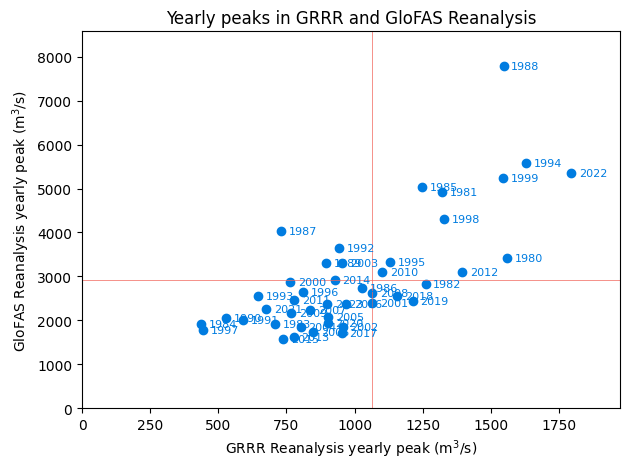

In [9]:
plot_yearly_peaks(
    df_all_peaks,
    "streamflow_max",
    "dis24_max",
    "GRRR Reanalysis yearly peak (m$^{3}$/s)",
    "GloFAS Reanalysis yearly peak (m$^{3}$/s)",
    rp_grrr,
    rp_glofas,
    "Yearly peaks in GRRR and GloFAS Reanalysis",
    f"temp/glofas_grrr_reanalysis_peaks_rp{rp}.png",
    80,
)

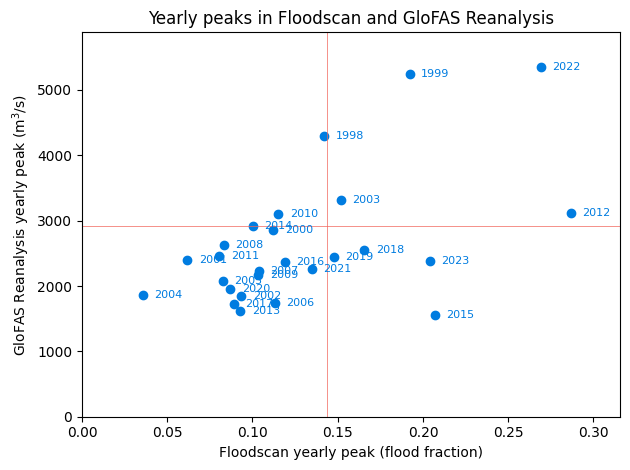

In [10]:
plot_yearly_peaks(
    df_all_peaks_fs,
    "sfed_max",
    "dis24_max",
    "Floodscan yearly peak (flood fraction)",
    "GloFAS Reanalysis yearly peak (m$^{3}$/s)",
    rp_fs,
    rp_glofas,
    "Yearly peaks in Floodscan and GloFAS Reanalysis",
    f"temp/glofas_floodscan_reanalysis_peaks_rp{rp}.png",
    0.015,
)

In [11]:
df_all_peaks_fs["detection_glofas"] = df_all_peaks_fs.apply(
    lambda row: determine_detection_type(
        row, rp_fs, rp_glofas, "sfed_max", "dis24_max"
    ),
    axis=1,
)

counts_glofas = df_all_peaks_fs["detection_glofas"].value_counts().to_dict()
precision, recall, f1 = get_more_stats(
    counts_glofas["TP"], counts_glofas["FP"], counts_glofas["FN"]
)
print("------ GloFAS detection stats agains Floodscan ------")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

------ GloFAS detection stats agains Floodscan ------
Precision: 0.6666666666666666
Recall: 0.5
F1: 0.5714285714285714


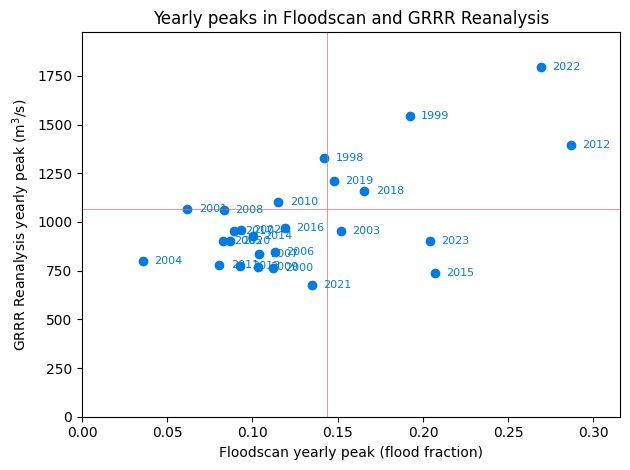

In [12]:
plot_yearly_peaks(
    df_all_peaks_fs,
    "sfed_max",
    "streamflow_max",
    "Floodscan yearly peak (flood fraction)",
    "GRRR Reanalysis yearly peak (m$^{3}$/s)",
    rp_fs,
    rp_grrr,
    "Yearly peaks in Floodscan and GRRR Reanalysis",
    f"temp/grrr_floodscan_reanalysis_peaks_rp{rp}.png",
    0.015,
)

In [13]:
df_all_peaks_fs["detection_grrr"] = df_all_peaks_fs.apply(
    lambda row: determine_detection_type(
        row, rp_fs, rp_grrr, "sfed_max", "streamflow_max"
    ),
    axis=1,
)

counts_glofas = df_all_peaks_fs["detection_grrr"].value_counts().to_dict()
precision, recall, f1 = get_more_stats(
    counts_glofas["TP"], counts_glofas["FP"], counts_glofas["FN"]
)
print("------ GRRR detection stats agains Floodscan ------")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

------ GRRR detection stats agains Floodscan ------
Precision: 0.625
Recall: 0.625
F1: 0.625


What if we triggered when GRRR > 3-year RP?

In [14]:
df_grrr_events = (
    df_ra_grrr[df_ra_grrr["streamflow"] > rp_grrr]
    .groupby(df_ra_grrr["valid_time"].dt.year.rename("year"))
    .first()
    .reset_index()
)[["year", "valid_time"]]

df_glofas_events = (
    df_ra_glofas[df_ra_glofas["dis24"] > rp_glofas]
    .groupby(df_ra_glofas["valid_time"].dt.year.rename("year"))
    .first()
    .reset_index()
)[["year", "valid_time"]]

df_fs_events = (
    df_fs[df_fs["SFED"] > rp_fs]
    .groupby(df_fs["valid_time"].dt.year.rename("year"))
    .first()
    .reset_index()
)[["year", "valid_time"]]

What do the other datasets look like at these events?

In [15]:
def get_continuous_periods(mask):
    """Returns list of (start_idx, end_idx) tuples for continuous True periods in mask"""
    if not any(mask):
        return []

    mask_array = np.array(mask)
    result = []

    start_idx = None
    for i, val in enumerate(mask_array):
        if val and start_idx is None:  # Start of a run
            start_idx = i
        elif not val and start_idx is not None:  # End of a run
            result.append((start_idx, i - 1))
            start_idx = None

    # Handle case where the last run extends to the end
    if start_idx is not None:
        result.append((start_idx, len(mask_array) - 1))

    return result

In [16]:
# Get all the events
df_events = pd.concat([df_fs_events, df_grrr_events]).sort_values("year")
df_events = df_events[
    (df_events.year >= 1998) & (df_events.year < 2024)
].reset_index()

df_merged = df_ra_grrr.merge(df_fs, how="inner")

In [17]:
# Just get the flooding season
df_merged["month"] = df_merged.valid_time.dt.month
df_merged["year"] = df_merged.valid_time.dt.year
df_merged = df_merged[(df_merged.month > 7) & (df_merged.month < 12)]

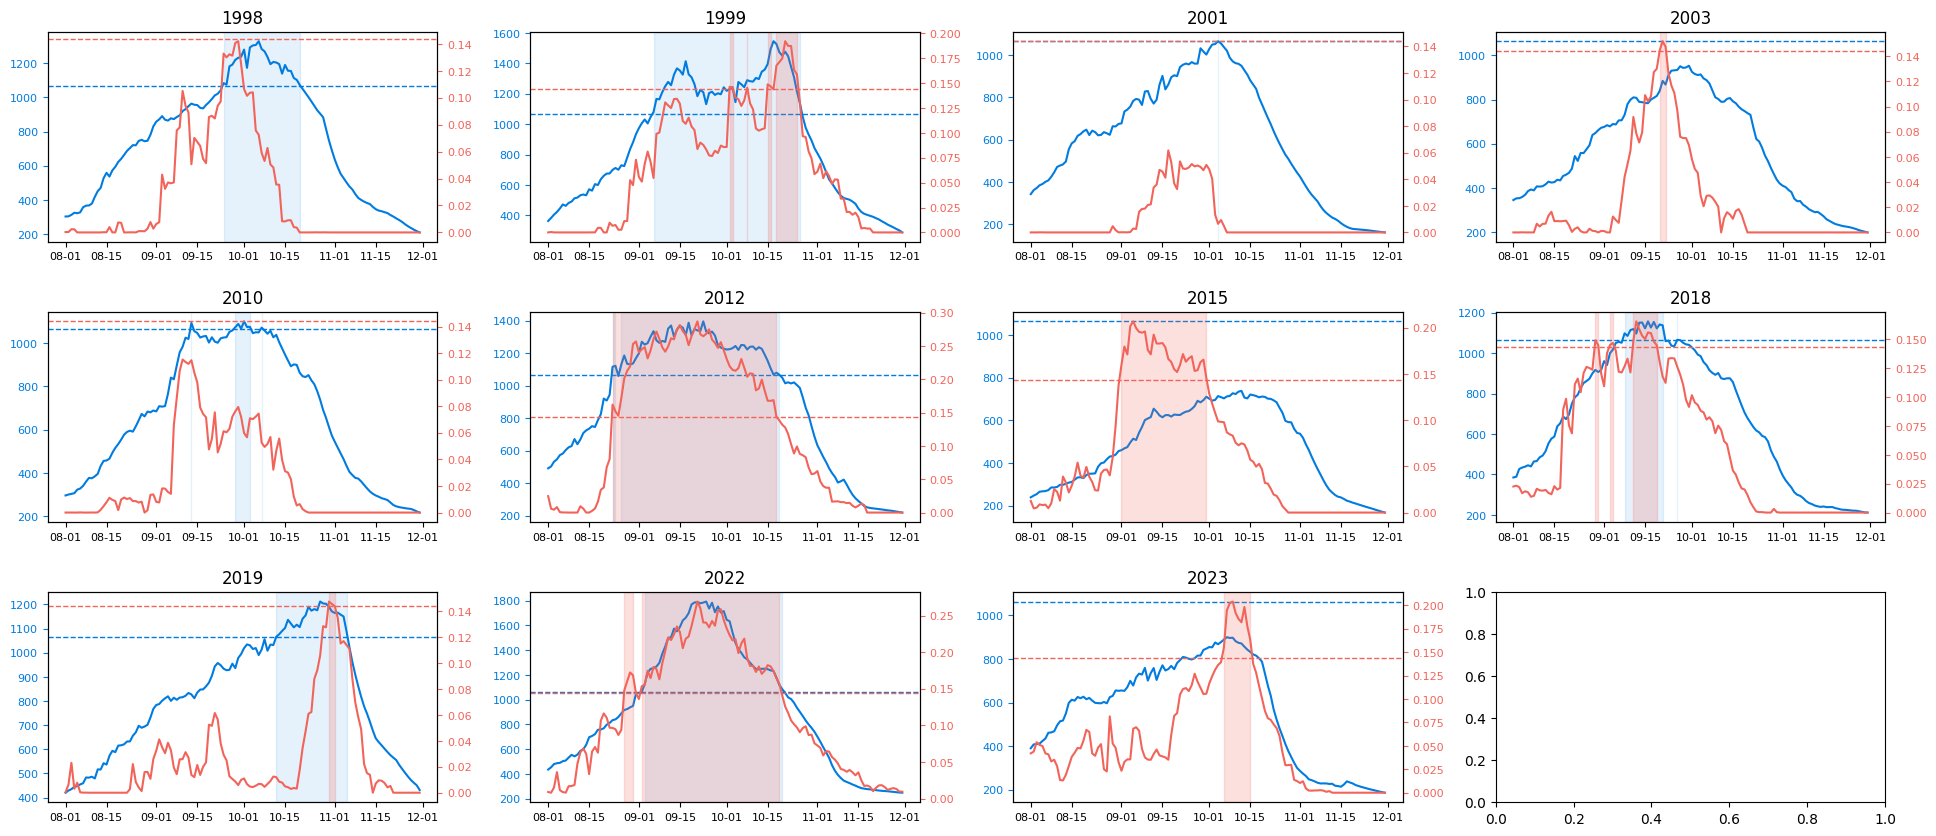

In [18]:
n_years = df_events["year"].nunique()
ncols = 4
nrows = round(n_years / ncols)

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3)
)
axes = axes.flatten()

for j, year in enumerate(df_events["year"].unique()):
    dff = df_merged[df_merged["valid_time"].dt.year == year]
    ax = axes[j]
    ax2 = ax.twinx()

    ax.plot(dff["valid_time"], dff["streamflow"], c=SAPPHIRE)
    ax2.plot(dff["valid_time"], dff["SFED"], c=TOMATO)

    axes[j].xaxis.set_major_formatter(DateFormatter("%m-%d"))

    # Highlight streamflow exceedances
    mask = dff["streamflow"] > rp_grrr
    periods = list(get_continuous_periods(mask))

    # Color y-axis labels and ticks
    ax.tick_params(axis="y", colors=SAPPHIRE, labelsize=8)
    ax2.tick_params(axis="y", colors=TOMATO, labelsize=8)

    # Make x-axis font smaller
    ax.tick_params(axis="x", labelsize=8)

    for start_idx, end_idx in get_continuous_periods(mask):
        ax.axvspan(
            dff["valid_time"].iloc[start_idx],
            dff["valid_time"].iloc[end_idx],
            alpha=0.1,
            color=SAPPHIRE,
        )

    # Highlight SFED exceedances
    mask = dff["SFED"] > rp_fs
    for start_idx, end_idx in get_continuous_periods(mask):
        ax2.axvspan(
            dff["valid_time"].iloc[start_idx],
            dff["valid_time"].iloc[end_idx],
            alpha=0.2,
            color=TOMATO,
        )
    ax.axhline(rp_grrr, lw=1, c=SAPPHIRE, linestyle="--")
    ax2.axhline(rp_fs, lw=1, c=TOMATO, linestyle="--")
    ax.set_title(year)

# Add more spacing to avoid overlap
plt.tight_layout(h_pad=2.0, w_pad=1.0, pad=3.0)
plt.savefig(f"temp/grrr_events_rp{rp}.png")

Let's look at the overall correlation across roughly the flooding season

In [19]:
# glofas vs floodscan
df_merged_glofas = df_fs.merge(df_ra_glofas, how="inner")

df_merged_glofas["month"] = df_merged_glofas.valid_time.dt.month
df_merged_glofas = df_merged_glofas[
    (df_merged_glofas.month > 7) & (df_merged_glofas.month < 12)
]

corr_glofas = df_merged_glofas["SFED"].corr(
    df_merged_glofas["dis24"], method="spearman"
)
print(corr_glofas)

0.6800855356773761


In [20]:
# grrr vs floodscan
df_merged_grrr = df_fs.merge(df_ra_grrr, how="inner")

df_merged_grrr["month"] = df_merged_grrr.valid_time.dt.month
df_merged_grrr = df_merged_grrr[
    (df_merged_grrr.month > 7) & (df_merged_grrr.month < 12)
]

corr_grrr = df_merged_grrr["SFED"].corr(
    df_merged_grrr["streamflow"], method="spearman"
)
print(corr_grrr)

0.6951278240841906
